In [1]:
import time
import warnings
import gymnasium as gym
import pandas as pd
import matplotlib.pyplot as plt

from environment.env import ShogiEnv
from agent.shogi_agent import ShogiAgent

warnings.filterwarnings("ignore")

gym.register(id="Shogi-v0", entry_point="environment.env:ShogiEnv")
env: ShogiEnv = gym.make("Shogi-v0")
agent = ShogiAgent()
agent.get_model("models/shogi-agent.pth")

In [40]:
# import zipfile

# # Compress the model_scripted.pt file
# with zipfile.ZipFile('models/shogi-agent.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
#     zipf.write('models/shogi-agent.pth')

In [15]:
# import torch
# import torch.nn as nn   
# import gzip
# import os

# state_dict_path = 'models/test2.pth'

# torch.save(agent.target_network.state_dict(), state_dict_path)

# compressed_path = state_dict_path + '.gz'

# with open(state_dict_path, 'rb') as f_in, gzip.open(compressed_path, 'wb') as f_out:
#     f_out.writelines(f_in)

# os.remove(state_dict_path)

In [ ]:
# decompressed_path = state_dict_path
# with gzip.open(compressed_path, 'rb') as f_in, open(decompressed_path, 'wb') as f_out:
#     f_out.write(f_in.read())

# model_loaded = agent.target_network()
# model_loaded.load_state_dict(torch.load(decompressed_path))

# os.remove(decompressed_path)

In [2]:
def play_game(environment: ShogiEnv, player: ShogiAgent) -> (float, bool, bool):
    losses = []
    rewards = []
    terminated = False
    truncated = False
    state = environment.reset()
    # agent.reset()

    while not terminated and not truncated:
        current_state = state

        # Take action
        current_state_valid_moves, _ = player.mask_and_valid_moves(environment)
        action, mask_index = player.select_action(environment)
        state, reward, terminated, truncated, _ = environment.step(action)
        next_state_valid_moves, _ = player.mask_and_valid_moves(environment)

        # Update the player
        # player.adaptive_e_greedy()
        player.remember(
            1 + reward,
            mask_index,
            reward,
            (terminated or truncated),
            current_state,
            current_state_valid_moves,
            state,
            next_state_valid_moves,
        )
        loss = player.train_model()

        rewards.append(reward)
        losses.append(loss)

    return rewards, terminated, truncated, losses

## Train the Agent

In [3]:
progress = []

In [4]:
df = pd.read_csv("progress.csv")

for i in range(len(df)):
    progress.append(
        {
            "reward": df["reward"].values[i],
            "loss": df["loss"].values[i],
            "terminated": df["terminated"].values[i],
            "truncated": df["truncated"].values[i],
            "duration": df["duration"].values[i]
        }
    )

In [10]:
agent.reset()

for i in range(11):
    start = time.time()
    reward_list, _terminated, _truncated, loss_list = play_game(env, agent)
    # Update the agent
    agent.adaptive_e_greedy()
    end = time.time()
    print(f"{i}: {end - start} seconds, {sum(reward_list)} reward, {sum(loss_list)} loss")

    progress.append(
        {
            "reward": sum(reward_list),
            "loss": sum(loss_list),
            "terminated": _terminated,
            "truncated": _truncated,
            "duration": end - start,
        }
    )

0: 515.6107864379883 seconds, 157.0 reward, 20572.46149109777 loss
1: 550.711681842804 seconds, 112.0 reward, 5361.14400131478 loss
2: 558.7493019104004 seconds, 80.0 reward, 5246.440423312069 loss
3: 524.8143255710602 seconds, 52.0 reward, 4745.327249937559 loss
4: 520.1503987312317 seconds, 134.0 reward, 5017.00521351294 loss
5: 520.6419713497162 seconds, 88.0 reward, 6204.379465283672 loss
6: 523.5610761642456 seconds, 153.0 reward, 5735.941230190724 loss
7: 522.0793032646179 seconds, 123.0 reward, 7528.193781237591 loss
8: 524.0713169574738 seconds, 116.0 reward, 7525.067184002772 loss
9: 522.8660426139832 seconds, 124.0 reward, 6527.528456277358 loss
10: 525.2950546741486 seconds, 160.0 reward, 6556.719591400643 loss


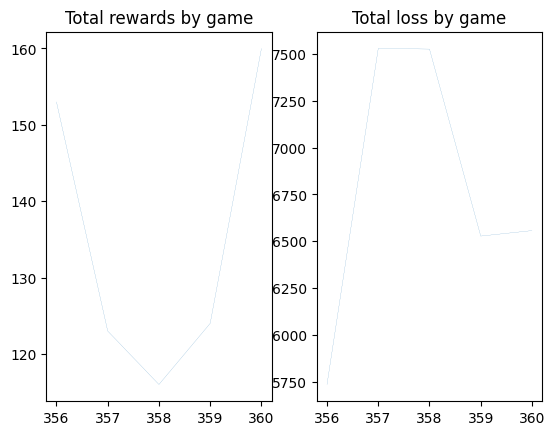

In [13]:
df = pd.DataFrame.from_records(progress)

plot_df = df.tail(5)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(plot_df.index, plot_df["reward"], linewidth=0.1)
ax1.set_title("Total rewards by game")

ax2.plot(plot_df.index, plot_df["loss"], linewidth=0.1)
ax2.set_title("Total loss by game")

# Show the plot
plt.show()

In [14]:
df.tail(5)

,reward,loss,terminated,truncated,duration
356,153.0,5735.941230,False,True,523.561076
357,123.0,7528.193781,False,True,522.079303
358,116.0,7525.067184,False,True,524.071317
359,124.0,6527.528456,False,True,522.866043
360,160.0,6556.719591,False,True,525.295055


In [15]:
# from torch.nn.utils import prune
# import torch

# print("Before pruning")
# for param_tensor in agent.target_network.state_dict():
#     print(param_tensor, "\t", agent.target_network.state_dict()[param_tensor].size())

In [16]:
# parameters_to_prune = (
#     (agent.target_network.conv1, 'weight'),
#     (agent.target_network.conv2, 'weight'),
#     (agent.target_network.conv3, 'weight'),
#     (agent.target_network.conv4, 'weight'),
#     (agent.target_network.fc1, 'weight'),
#     (agent.target_network.fc2, 'weight'),
# )

# prune.global_unstructured(
#     parameters_to_prune,
#     pruning_method=prune.L1Unstructured,
#     amount=0.4,
# )

# print("After pruning")
# for param_tensor in agent.target_network.state_dict():
#     print(param_tensor, "\t", agent.target_network.state_dict()[param_tensor].size())

# torch.save(agent.target_network.state_dict(), "models/pruned_shogi-agent.pth")

In [17]:
agent.save_model("models/shogi-agent.pth")

In [18]:
df.to_csv("progress.csv", index=False)